In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

In [3]:
df = pd.read_csv('data/electric_demand/energy_dataset.csv')
df = df[['time','total load actual']]

temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
df['time'] = temp_s

temp_df = df.groupby('time').agg('mean').reset_index()

In [4]:
train_len = 1000
valid_len = 100

input_size = 365 # lookback horizon
output_size = 7 # forecast horizon

train_df = temp_df.iloc[:train_len,-1]
valid_df = temp_df.iloc[train_len-input_size:train_len+valid_len,-1]
test_df = temp_df.iloc[train_len+valid_len-input_size:,-1]

In [5]:
train_df = np.expand_dims(train_df.to_numpy(),axis=1)
valid_df = np.expand_dims(valid_df.to_numpy(),axis=1)
test_df = np.expand_dims(test_df.to_numpy(),axis=1)

scaler = StandardScaler()
train_df = pd.DataFrame(np.squeeze(scaler.fit_transform(train_df)))
valid_df = pd.DataFrame(np.squeeze(scaler.transform(valid_df)))
test_df = pd.DataFrame(np.squeeze(scaler.transform(test_df)))

In [6]:
def process_series(df, input_size, output_size, stride):

    X = np.empty(shape=(1,input_size,1))
    y = np.empty(shape=(1,input_size))

    for idx, _ in df.iterrows():
        
        if idx % stride == 0 and idx+input_size+output_size <= len(df):
            
            input_values = (df.iloc[idx:idx+input_size]).to_numpy()
            input_values = np.expand_dims(input_values,0)

            output_values = (df.iloc[idx+output_size:idx+input_size+output_size]).to_numpy().T
            
            X = np.concatenate((X,input_values))
            y = np.concatenate((y,output_values))
    
    return X[1:],y[1:]

train_X, train_y = process_series(train_df, input_size, output_size, 1)
valid_X, valid_y = process_series(valid_df, input_size, output_size, 7)
test_X, test_y = process_series(test_df, input_size, output_size, 7)

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

# basic 2-layer network
class Vanilla_TCN(tf.keras.Model):

    def __init__(self):
        super(Vanilla_TCN, self).__init__()
        self.conv_1 = tfkl.Conv1D(filters=10,kernel_size=3,dilation_rate=1, padding='causal', activation='relu')
        self.conv_2 = tfkl.Conv1D(filters=1,kernel_size=3,dilation_rate=1, padding='causal')
    
    def call(self, x):
        h = self.conv_1(x)
        out = self.conv_2(h)
        
        return out

In [11]:
class TCN_Block(tf.keras.Model):

    def __init__(self,num_filters, k, d, last=False, first=False):
        super(TCN_Block, self).__init__()
        self.first = first
        self.last = last
        
        self.conv1 = tfkl.Conv1D(filters=num_filters,kernel_size=k,dilation_rate=d, padding='causal')
        if last:
            self.conv2 = tfkl.Conv1D(filters=1,kernel_size=k,dilation_rate=d, padding='causal')
        else:
            self.conv2 = tfkl.Conv1D(filters=num_filters,kernel_size=k,dilation_rate=d, padding='causal')

        if first:
            self.short_conv = tfkl.Conv1D(filters=num_filters,kernel_size=1)
        elif last:
            self.short_conv = tfkl.Conv1D(filters=1,kernel_size=1)

        self.relu1 = tfkl.ReLU()
        self.relu2 = tfkl.ReLU()


    def call(self, x):

        h = self.conv1(x)
        h = self.relu1(h)
        h = self.conv2(h)

        # shortcut
        if self.first or self.last:
            h = h + self.short_conv(x)
        else:
            h = h + x

        # last activation
        if self.last:
            out = h
        else:
            out = self.relu2(h)

        return out


class TCN(tf.keras.Model):

    def __init__(self, num_layers, num_filters, kernel_size, dilation_base):
        super(TCN, self).__init__()

        self.seq = tf.keras.Sequential()

        for i in range(num_layers):
            if i==0:
                self.seq.add(TCN_Block(num_filters, kernel_size, dilation_base**i, first=True))
            elif i==num_layers-1:
                self.seq.add(TCN_Block(num_filters, kernel_size, dilation_base**i, last=True))
            else:
                self.seq.add(TCN_Block(num_filters, kernel_size, dilation_base**i))
    
    def call(self, x):
        
        out = self.seq(x)
        
        return out

In [17]:
model = TCN(num_layers=4,num_filters=5,kernel_size=7,dilation_base=2)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,cooldown=3,verbose=1)

model.compile(loss=loss, optimizer=optimizer)

model.fit(x=train_X, y=train_y, epochs=10, batch_size=32, validation_data=(valid_X, valid_y), callbacks=[])

Epoch 1/10
20/20 [==============================] - 1s 25ms/step - loss: 1.0646 - val_loss: 1.0869
Epoch 2/10
20/20 [==============================] - 0s 15ms/step - loss: 0.9614 - val_loss: 1.0279
Epoch 3/10
20/20 [==============================] - 0s 15ms/step - loss: 0.9149 - val_loss: 0.9739
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 0.8391 - val_loss: 0.8715
Epoch 5/10
20/20 [==============================] - 0s 15ms/step - loss: 0.7254 - val_loss: 0.7911
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 0.6528 - val_loss: 0.7479
Epoch 7/10
20/20 [==============================] - 0s 15ms/step - loss: 0.6043 - val_loss: 0.7152
Epoch 8/10
20/20 [==============================] - 0s 14ms/step - loss: 0.5634 - val_loss: 0.6994
Epoch 9/10
20/20 [==============================] - 0s 16ms/step - loss: 0.5253 - val_loss: 0.6762
Epoch 10/10
20/20 [==============================] - 0s 14ms/step - loss: 0.4896 - val_loss: 0.6474


valid | MAE: 2000.91, RMSE: 2498.44, MAPE: 0.07
test  | MAE: 2114.05, RMSE: 2702.22, MAPE: 0.07


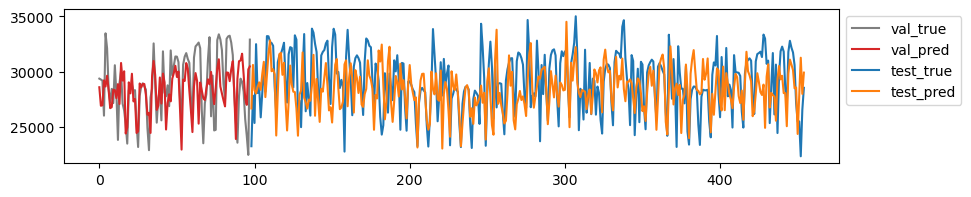

In [18]:
valid_preds = np.expand_dims((model.predict(valid_X)[:,-output_size:,0]).flatten(),0)
y_pred_valid = np.squeeze(scaler.inverse_transform(valid_preds))

y_true_valid = temp_df.iloc[train_len:train_len+len(y_pred_valid),-1].values

test_preds = np.expand_dims((model.predict(test_X)[:,-output_size:,0]).flatten(),0)
y_pred_test = np.squeeze(scaler.inverse_transform(test_preds))

y_true_test = temp_df.iloc[train_len+valid_len:train_len+valid_len+len(y_pred_test),-1].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(y_true_valid))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(y_true_test)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()